In [7]:
import os
import pandas as pd
import numpy as np
import h2o
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from ai_data_science_team.ml_agents import H2OMLAgent

In [8]:
# 1.0 LOADING VARIABLES AND GROQ CONFIGURATION
load_dotenv()

# Configure LangChain to communicate with Groq using the OpenAI interface
GROQ_MODEL = "meta-llama/llama-4-scout-17b-16e-instruct" # "openai/gpt-oss-120b"

llm = ChatOpenAI(
    model=GROQ_MODEL,
    openai_api_key=os.getenv("GROQ_API_KEY"),
    openai_api_base="https://api.groq.com/openai/v1" # Redirect calls to Groq
)

llm

ChatOpenAI(profile={}, client=<openai.resources.chat.completions.completions.Completions object at 0x0000023A16807350>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000023A168D4D10>, root_client=<openai.OpenAI object at 0x0000023A168D7910>, root_async_client=<openai.AsyncOpenAI object at 0x0000023A168E0150>, model_name='meta-llama/llama-4-scout-17b-16e-instruct', model_kwargs={}, openai_api_key=SecretStr('**********'), openai_api_base='https://api.groq.com/openai/v1')

In [9]:
# 2.0 PATHS AND DATA
PATH_ROOT = "btc_forecast/"
MODEL_PATH = os.path.join(os.getcwd(), PATH_ROOT, "h2o_models/")
LOG_PATH = os.path.join(os.getcwd(), PATH_ROOT, "ai_logs/")
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(LOG_PATH, exist_ok=True)

df = pd.read_csv("data/all_together/dataset_X_and_y_mfe_log.csv", low_memory=False)

# --- NEW PREVENTIVE CLEANING ---
# Remove problematic columns
cols_to_drop = ['anchor_t', 'df_macroeconomic_data__DowJones_Volume_yf']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# FORCE EVERYTHING TO NUMERIC: This avoids NullPointerException in H2O
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 1. Infinite Management: Replace Inf with NaN
df = df.replace([np.inf, -np.inf], np.nan)
# 2. Remove columns with too many missing values (e.g., over 50% NaN)
# This greatly helps GLM stability
threshold = len(df) * 0.5
df = df.dropna(thresh=threshold, axis=1)

# Remove columns with only one unique value (constants) or all NaN after conversion
df = df.loc[:, df.nunique() > 1]
print(f"Cleaned dataset. Remaining columns: {len(df.columns)}")

Cleaned dataset. Remaining columns: 378


In [10]:
help(H2OMLAgent)

Help on class H2OMLAgent in module ai_data_science_team.ml_agents.h2o_ml_agent:

class H2OMLAgent(ai_data_science_team.templates.agent_templates.BaseAgent)
 |  H2OMLAgent(model, n_samples=30, log=False, log_path=None, file_name='h2o_automl.py', function_name='h2o_automl', model_directory=None, overwrite=True, human_in_the_loop=False, bypass_recommended_steps=False, bypass_explain_code=False, enable_mlflow=False, mlflow_tracking_uri=None, mlflow_artifact_root=None, mlflow_experiment_name='H2O AutoML', mlflow_run_name=None, checkpointer: Union[NoneType, bool, langgraph.checkpoint.base.BaseCheckpointSaver] = None)
 |  
 |  A Machine Learning agent that uses H2O's AutoML for training,
 |  allowing the user to specify a model directory for saving the best model.
 |  If neither model_directory nor log_path is provided, model saving is skipped.
 |  
 |  Parameters
 |  ----------
 |  model : langchain.llms.base.LLM
 |      The language model used to generate the ML code.
 |  n_samples : int, o

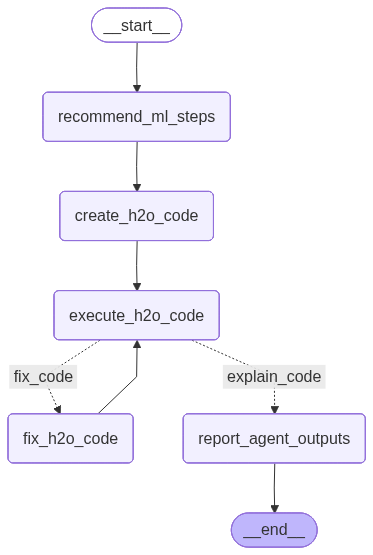

In [11]:
# 3.0 AGENT INITIALIZATION
# The agent will use Groq to "think" and H2O to "execute" models
ml_agent = H2OMLAgent(
    model=llm,
    log=True,
    log_path=LOG_PATH,
    model_directory=MODEL_PATH,
    enable_mlflow=True,
)

ml_agent

In [15]:
help(ml_agent.invoke_agent)

Help on method invoke_agent in module ai_data_science_team.ml_agents.h2o_ml_agent:

invoke_agent(data_raw: pandas.core.frame.DataFrame, user_instructions: str = None, target_variable: str = None, max_retries=3, retry_count=0, **kwargs) method of ai_data_science_team.ml_agents.h2o_ml_agent.H2OMLAgent instance
    Synchronously trains an H2O AutoML model for the provided dataset,
    saving the best model to disk if model_directory or log_path is available.



In [16]:
max_runtime_secs = 1800 
max_retries = 10
max_models = 50

with open("prompt.txt", "r") as f:
    instructions_template = f.read()

instructions = instructions_template.replace("{max_runtime_secs}", str(max_runtime_secs))

technical_constraints = f"""
---
CRITICAL TECHNICAL RULES:
1. FORBIDDEN METHODS: Do not use h2o.cluster().is_running(). H2O will fail.
2. SIMPLICITY: Just call h2o.init() and then h2o.H2OFrame(pd.DataFrame(data_raw)).
3. PANDAS: Only use pandas for the initial conversion. After that, use H2O methods ONLY.
4. Use max_models={max_models} in the function h2o_automl
---
"""

full_instructions = instructions + technical_constraints

print(f"🚀 Session started ({max_runtime_secs}s, {max_retries} retries)...")

ml_agent.invoke_agent(
    data_raw=df,
    user_instructions=full_instructions,
    target_variable="y_mfe_log",
    max_retries=max_retries
)

🚀 Session started (1800s, 10 retries)...
---H2O ML AGENT----
    * RECOMMEND MACHINE LEARNING STEPS
    * CREATE H2O AUTOML CODE
      File saved to: c:\Users\Alessandro\Desktop\Cartelle\Mie\Programmi personali in Python\Forecasting BTC with ai-data-science-team\btc_forecast/ai_logs/h2o_automl.py
    * EXECUTING AGENT CODE
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.411-b09, mixed mode)
  Starting server from C:\Users\Alessandro\Desktop\Cartelle\Mie\Programmi personali in Python\Forecasting BTC with ai-data-science-team\.venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ALESSA~1\AppData\Local\Temp\tmp7xe2up2e
  JVM stdout: C:\Users\ALESSA~1\AppData\Local\Temp\tmp7xe2up2e\h2o_Alessandro_started_from_python.out
  JVM stderr: C:\Users\ALESSA~1\AppData\Local\Temp\tmp7xe2up2e\h2o_Alessandro_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,07 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,1 month and 15 days
H2O_cluster_name:,H2O_from_python_Alessandro_qwz8dh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.298 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
12:43:14.35: AutoML: XGBoost is not available; skipping it.

███████
12:43:49.45: GLM_1_AutoML_1_20260109_124313 [GLM def_1] failed: java.lang.NullPointerException

████████████████████████████████████████████████████████| (done) 100%
dtype is only supported for one column frames
      Error logged to: c:\Users\Alessandro\Desktop\Cartelle\Mie\Programmi personali in Python\Forecasting BTC with ai-data-science-team\btc_forecast/ai_logs/h2o_automl.py_errors.log
    * FIX AGENT CODE
      retry_count:0
      File saved to: c:\Users\Alessandro\Desktop\Cartelle\Mie\Programmi personali in Python\Forecasting BTC with ai-data-science-team\btc_forecast/ai_logs/h2o_automl.py
    * EXECUTING AGENT CODE
Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,13 mins 28 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,1 month and 15 days
H2O_cluster_name:,H2O_from_python_Alessandro_qwz8dh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.205 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
12:56:47.429: AutoML: XGBoost is not available; skipping it.

█████
12:57:18.386: GLM_1_AutoML_2_20260109_125647 [GLM def_1] failed: java.lang.NullPointerException

█████████████████████████████████████████████████████████| (done) 100%
dtype is only supported for one column frames
      Error logged to: c:\Users\Alessandro\Desktop\Cartelle\Mie\Programmi personali in Python\Forecasting BTC with ai-data-science-team\btc_forecast/ai_logs/h2o_automl.py_errors.log
    * FIX AGENT CODE
      retry_count:1
      File saved to: c:\Users\Alessandro\Desktop\Cartelle\Mie\Programmi personali in Python\Forecasting BTC with ai-data-science-team\btc_forecast/ai_logs/h2o_automl.py
    * EXECUTING AGENT CODE
Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,28 mins 48 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,1 month and 15 days
H2O_cluster_name:,H2O_from_python_Alessandro_qwz8dh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.954 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
13:12:06.58: AutoML: XGBoost is not available; skipping it.
13:12:06.487: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 28.0.

██████████████████████████████████████████████████████████████| (done) 100%
dtype is only supported for one column frames
      Error logged to: c:\Users\Alessandro\Desktop\Cartelle\Mie\Programmi personali in Python\Forecasting BTC with ai-data-science-team\btc_forecast/ai_logs/h2o_automl.py_errors.log
    * FIX AGENT CODE
      retry_count:2
      File saved to: c:\Users\Alessandro\Desktop\Cartelle\Mie\Programmi personali in Python\Forecasting BTC with ai-data-science-team\btc_forecast/ai_logs/h2o_automl.py
    * EXECUTING AGENT CODE
Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,31 mins 15 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,1 month and 15 days
H2O_cluster_name:,H2O_from_python_Alessandro_qwz8dh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.140 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
13:14:33.2: AutoML: XGBoost is not available; skipping it.
13:14:33.252: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 28.0.

██████████████████████████████████████████████████████████████| (done) 100%
dtype is only supported for one column frames
      Error logged to: c:\Users\Alessandro\Desktop\Cartelle\Mie\Programmi personali in Python\Forecasting BTC with ai-data-science-team\btc_forecast/ai_logs/h2o_automl.py_errors.log
    * FIX AGENT CODE
      retry_count:3
      File saved to: c:\Users\Alessandro\Desktop\Cartelle\Mie\Programmi personali in Python\Forecasting BTC with ai-data-science-team\btc_forecast/ai_logs/h2o_automl.py
    * EXECUTING AGENT CODE
      Error logged to: c:\Users\Alessandro\Desktop\Cartelle\Mie\Programmi personali in Python\Forecasting BTC with ai-data-science-t

H2O_cluster_uptime:,33 mins 35 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,1 month and 15 days
H2O_cluster_name:,H2O_from_python_Alessandro_qwz8dh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.098 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
13:16:52.929: AutoML: XGBoost is not available; skipping it.
13:16:53.182: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 28.0.

██████████████████████████████████████████████████████████████| (done) 100%


c:\Users\Alessandro\Desktop\Cartelle\Mie\Programmi personali in Python\Forecasting BTC with ai-data-science-team\.venv\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
2026/01/09 13:18:52 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/09 13:18:52 INFO mlflow.store.db.utils: Updating database tables
2026/01/09 13:18:52 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/09 13:18:52 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/09 13:18:53 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/01/09 13:18:53 INFO alembic.runtime.migration: Running upgrade 451aebb31d03

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,36 mins 07 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,1 month and 15 days
H2O_cluster_name:,H2O_from_python_Alessandro_qwz8dh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.087 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


    * REPORT AGENT OUTPUTS


In [17]:
# 5.0 RESULTS AND LOGS
print("\n--- MODEL LEADERBOARD ---")
print(ml_agent.get_leaderboard())

print("\n--- WORKFLOW SUMMARY ---")
print(ml_agent.get_workflow_summary(markdown=True))


--- MODEL LEADERBOARD ---
                                             model_id       rmse          mse  \
0        GBM_grid_1_AutoML_5_20260109_131652_model_22   0.029815     0.000889   
1        GBM_grid_1_AutoML_5_20260109_131652_model_23   0.029865     0.000892   
2         GBM_grid_1_AutoML_5_20260109_131652_model_1   0.030281     0.000917   
3         GBM_grid_1_AutoML_5_20260109_131652_model_3   0.030612     0.000937   
4        GBM_grid_1_AutoML_5_20260109_131652_model_10   0.030694     0.000942   
5         GBM_grid_1_AutoML_5_20260109_131652_model_9   0.030781     0.000947   
6                      GBM_4_AutoML_5_20260109_131652   0.030862     0.000952   
7        GBM_grid_1_AutoML_5_20260109_131652_model_52   0.030903     0.000955   
8         GBM_grid_1_AutoML_5_20260109_131652_model_8   0.031132     0.000969   
9        GBM_grid_1_AutoML_5_20260109_131652_model_55   0.031199     0.000973   
10       GBM_grid_1_AutoML_5_20260109_131652_model_57   0.031265     0.000977   
1

In [ ]:
# 6.0 LOADING THE WINNING MODEL (H2O)
h2o.init()
model_path = ml_agent.get_model_path()
best_model = h2o.load_model(model_path)

print("\n✅ Best Model Loaded. Performance:")
print(best_model.model_performance())

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,37 mins 09 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,1 month and 15 days
H2O_cluster_name:,H2O_from_python_Alessandro_qwz8dh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.087 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"



✅ Best Model Loaded. Performance:
ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.0004360875665033196
RMSE: 0.020882709750013755
MAE: 0.013057986199523188
RMSLE: 0.020127607882830027
Mean Residual Deviance: 0.0004360875665033196


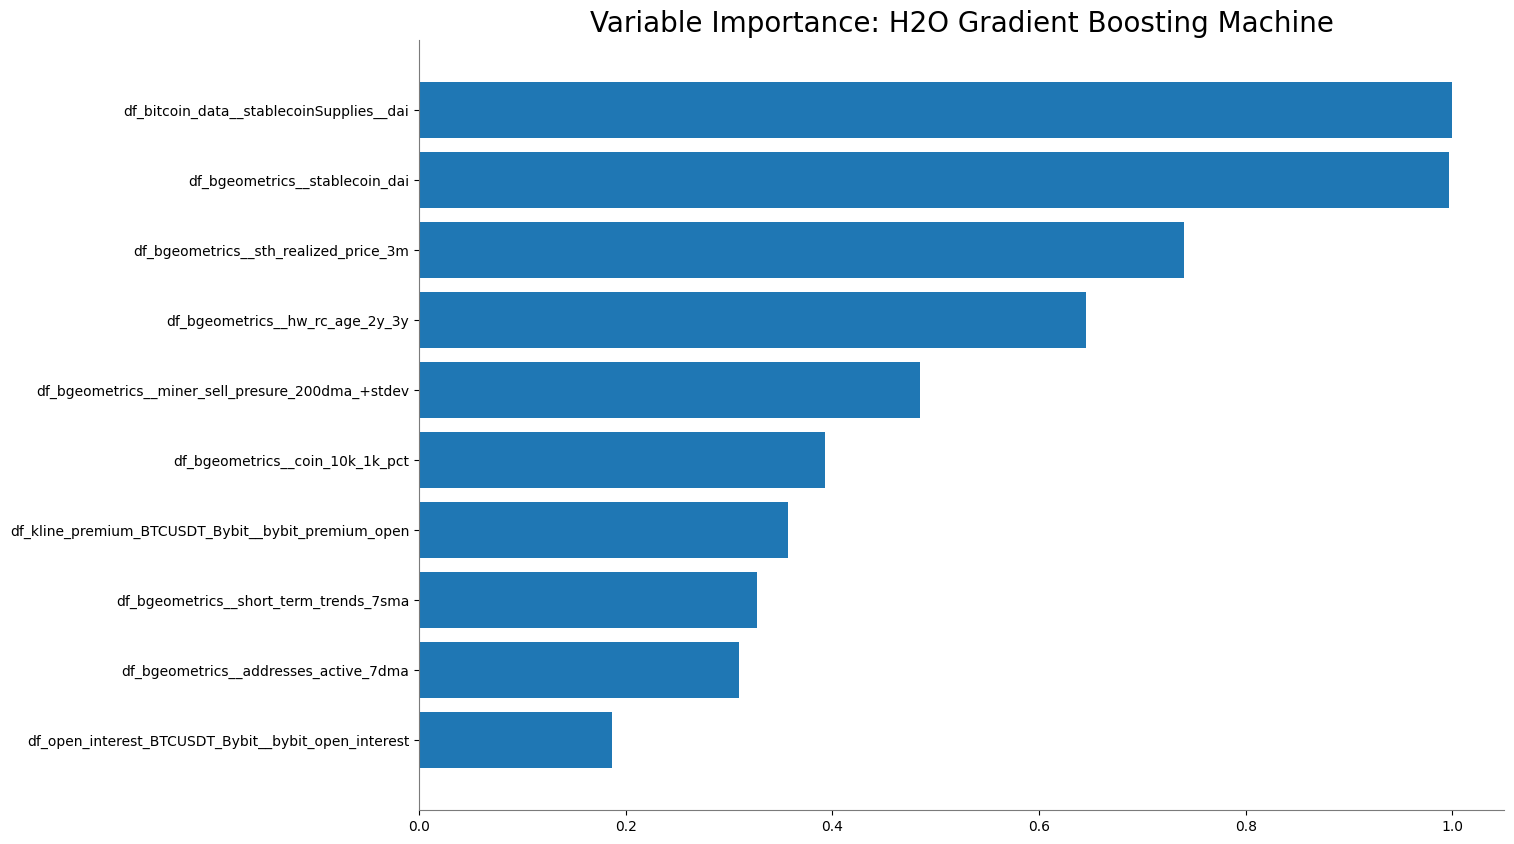

<Figure size 640x480 with 0 Axes>

In [19]:
# Look at which variables are most important
best_model.varimp_plot()